In [105]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng

rng = default_rng()

В первой ситуации эксперимент просто подтверждает аналитическую формулу $X_{(k+1)} − X_{(k)} ∼ Exp((n − k)α)$.

Как проходит эксперимент: на каждой итерации генерируется набор времени в окошке у уже сидящих там $n$ человек. Дальше время сортируется и находится разница между ожиданием соседей. Итоги усредняются по количеству итераций.  

Что это значит можно увидеть из графиков -- чем больше работает окошек, тем быстрее все работает. Чем ближе число окошек и число посетителей, тем больше разрыв в начале и в конце и тем дольше все работает. Параметр просто масштабирует всемя.  

In [0]:
def generate_first(n, qlen, iterations, rate):
    assert n >= qlen

    res = np.zeros(qlen)

    for i in range(iterations):
        a = rng.exponential(scale = rate, size=n)
        a.sort()
        res += a[:qlen] - np.concatenate([[0], a])[:qlen]

    return res / iterations

def limit_distribution(n, rate, k):
    return rate / (n - k + 1)

In [115]:
def draw(n = 100, qlen = 10, iterations = 100000, rate = 100):
    x = np.arange(1,qlen+1,1)    # start,stop,step
    y = generate_first(n, qlen, iterations, rate) 
    plt.plot(x, y, label="experiment")
    f = lambda k: limit_distribution(n, rate, k) 
    y = list(map(f, x))
    plt.plot(x, y, label="limit distribution")
    plt.grid()
    plt.legend()
    plt.title("n = " + str(n) + " queue length = " + str(qlen) + " rate = " + str(rate))
    plt.show()

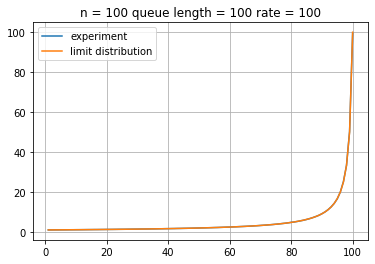

In [120]:
draw(n = 100, qlen = 10, iterations=100000, rate=100)
draw(n = 100, qlen = 10, iterations=100000, rate=10) # change rate

draw(n = 10, qlen = 10, iterations=100000, rate=100) # change n
draw(n = 100, qlen = 100, iterations=100000, rate=100) # change qlen

Как здесь устроен эксперимент: аналогично сначала $n$ человек заняли окошки и у каждого время работы распределено экспоненциально. То есть изначально есть $n$ отметок, когда окошко освободится. Из очереди приходят люди, как только какое-то окошко освободилось. То есть минимальное время выкидывается и добавляется время окончания нового человека из очереди. И такое повторяется, пока очередь не закончится. 

Выводы ниже. 

In [136]:
import heapq

def get_rnd_heap(rate, n):
    time_heap = rng.exponential(scale = rate, size=n).tolist()
    heapq.heapify(time_heap)
    return time_heap

def pop_min(heap):
    return heapq.heappop(heap) 

def add(heap, x):
    heapq.heappush(heap, x) # next one starts


def generate_second(n, qlen, iterations, rate):
    res = np.zeros(qlen)

    for i in range(iterations):
        prev = 0

        time_heap = get_rnd_heap(rate, n)
        for cur_id, worktime in enumerate(rng.exponential(scale=rate,size=qlen)):
            # get min time and add new time
            curtime = pop_min(time_heap) 
            assert curtime >= prev
            res[cur_id] += curtime - prev
            prev = curtime
            add(time_heap, curtime + worktime) # next one starts working
        
    return res / iterations

In [192]:
def draw_second(n = 20, qlen = 10, iterations = 100000, rate = 100):
    x = np.arange(1,qlen+1,1)    # start,stop,step
    y = generate_second(n, qlen, iterations, rate) 
    plt.plot(x, y, label = "experiment")
    plt.grid()
    plt.hlines(y=rate/n, xmin=1, xmax=qlen, colors='orange', linestyles='-', lw=2, label='rate/n')
    plt.legend()    
    plt.title("n = " + str(n) + " queue length = " + str(qlen) + " rate = " + str(rate))

    plt.show()


Выводы получились такие -- разница времени ожидания между соседями в очереди не зависит от k и примерно соответствует $\frac{rate}{n}$

Серия экспериментов:

Эксперимент с одним окошком и 10 людьми в очереди и 100 единицами времени в среднем на обработку. Здесь просто экспоненциальное время между двумя людьми, логично, что ничего не зависит от номера в очереди

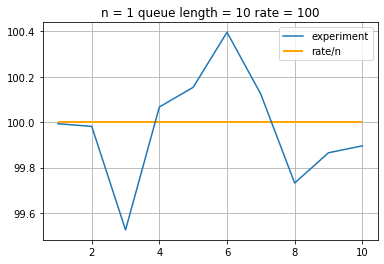

In [193]:
draw_second(1,10,100000,100)

Увеличиваю количество окошек до 10. Теперь обработка человека из очереди в 10 раз быстрее. 

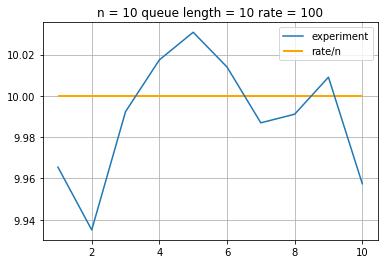

In [194]:
draw_second(10,10,100000,100)

Если увеличить еще в 10 раз, обработка так же в 10 раз быстрее. 

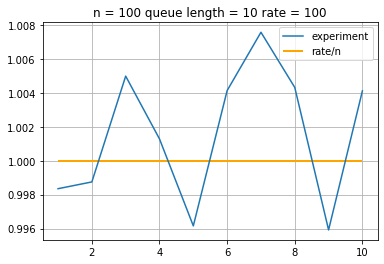

In [195]:
draw_second(100,10,100000,100)

Остановимся на 10 окошках. Если менять параметр распределения, то все меняется пропорционально: изменил среднее время обработки с 100 до 10 и все стало работать в 10 раз быстрее. 

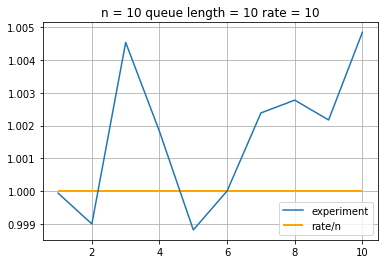

In [196]:
draw_second(10,10,100000,10)

На всякий случай еще в 10 раз меньше:

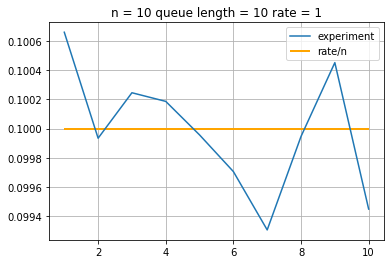

In [197]:
draw_second(10,10,100000,1)

Теперь посмотрим, что с изменением по длине очереди. В прошлых экспериментах уже было видно, что номер человека в очереди не влияет на время и всех в среднем одинаково обслуживают. Логично получается, что при изменении длины очереди тоже ничего не меняется:

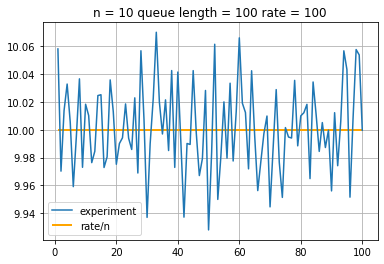

In [198]:
draw_second(10,3,100000,100)
draw_second(10,10,100000,100)
draw_second(10,100,100000,100)